## Solving satisfiability problems using Grover’s Algorithm
##### Quantum Computing - Final project 

Trabalho realizado por:
- Nelson Almeida (a95652)
- Nuno Costa (a97610)

## Criação da fórmula booleana 3-SAT
Consideremos a seguinte fórmula $f$,

$f(v1,v2,v3) = (\neg v1 \lor \neg v2 \lor \neg v3) \land (v1 \lor \neg v2 \lor v3) \land (v1 \lor v2 \lor \neg v3) \land (v1 \lor \neg v2 \lor \neg v3) \land (\neg v1 \lor v2 \lor v3)$

In [5]:
drawTable()

╒══════╤══════╤══════╤═════╤═══════════════╕
│   v1 │   v2 │   v3 │   f │ Comentário    │
╞══════╪══════╪══════╪═════╪═══════════════╡
│    0 │    0 │    0 │   1 │ Solução       │
├──────┼──────┼──────┼─────┼───────────────┤
│    0 │    0 │    1 │   0 │ Não é solução │
├──────┼──────┼──────┼─────┼───────────────┤
│    0 │    1 │    0 │   0 │ Não é solução │
├──────┼──────┼──────┼─────┼───────────────┤
│    0 │    1 │    1 │   0 │ Não é solução │
├──────┼──────┼──────┼─────┼───────────────┤
│    1 │    0 │    0 │   0 │ Não é solução │
├──────┼──────┼──────┼─────┼───────────────┤
│    1 │    0 │    1 │   1 │ Solução       │
├──────┼──────┼──────┼─────┼───────────────┤
│    1 │    1 │    0 │   1 │ Solução       │
├──────┼──────┼──────┼─────┼───────────────┤
│    1 │    1 │    1 │   0 │ Não é solução │
╘══════╧══════╧══════╧═════╧═══════════════╛


Pela observação da tabela lógica obtida, podemos concluir que, estamos perante uma fórmula booleana 3-SAT com solução, tal como pretendíamos.

Tendo em conta que sabemos para que valores a expressão toma o valor verdadeiro, podemos então modelar um algoritmo que os "force" para esses estados.

## Implementação do algoritmo de Grover

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, AncillaRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_distribution
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

In [3]:
def execute_circuit(qc, shots=1024, decimal=False, reversed=False):
    
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = execute(qc, device, shots=shots).result().get_counts()
    
    if decimal:
        if reversed:
            counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
        else:
            counts = dict((int(a,2),b) for (a,b) in counts.items())
    else:
        if reversed:
            counts = dict((a[::-1],b) for (a,b) in counts.items())
        else:
            counts = dict((a,b) for (a,b) in counts.items())

    return counts

#### O algoritmo de Grover é composto por três etapas: inicialização, oráculo e difusor. 

#### 1. Inicialização:
Começamos pela função "initializeCircuit" que é utilizada para criar e inicializar o circuito quântico.<br>
O circuito criado é composto por $numQubits$ registos quanticos, $numQubits$+1 registos quânticos auxiliares e $numQubits$ registos clássicos para a medição de resultados.<br>
Começamos por inicializar todos os qubits de $qr$ no estado de sobreposição uniforme, utilizando a Gate de Hadamard, posteriormente inicializamos a ancilla no estado 1 de sobreposição ($|->$).

In [4]:
def initializeCircuit(numQubits):
    qr = QuantumRegister(numQubits,name="v")
    ancilla = AncillaRegister(numQubits+1,name="ancilla")
    cr = ClassicalRegister(numQubits)
    qc = QuantumCircuit(qr,ancilla,cr)
    
    #uniform superposition qr
    qc.h(qr)
    #|-> state ancilla
    qc.x(ancilla)
    qc.h(ancilla)
    qc.barrier(label="Initialization Barrier")
    
    return qc,qr,ancilla,cr

#### 2. Oráculo:
A função de Oráuclo implementa a parte do algoritmo de Grover que permite marcar as soluções do nosso problema com fases negativas. Este é um passo essencial para o sucesso da nossa implementação<br>

Visto sabermos à $priori$ os valores para os quais a função retorna valor Verdadeiro podemos utilizar isso em nossa vantagem e marcar as soluções $|000>$, $|101>$ e $|110>$ resultados dados pela tabela acima.

In [5]:
def oracle(qr, ancilla, solutions):
    pos=0
    qc = QuantumCircuit(qr, ancilla)
    for solution in solutions:
        listOf0 = []
        posAssertion = 0
        for i in solution:
            #Marca os bits a 0 para serem negados
            if i=="0":
                listOf0.append(qr[posAssertion])
            posAssertion+=1
        #nega os bits a 0 da solução
        for i in listOf0:
            qc.x(i)
        #aplica a gate mcx e "coleciona" o resultado na ancilla
        qc.mcx(qr, ancilla[pos])
        
        #desfaz a negação dos bits a 0
        for i in listOf0:
            qc.x(i)
        pos+=1
    #aplica uma gate mcx sobre todos os bits das ancillas de controlo para a ancilla que "coleciona" o resultado final
    qc.mcx(ancilla[:-1], ancilla[-1])
    
    qc.barrier(label="Oracle Barrier")
    return qc

#### 3. Operador de difusão:
Por fim, definimos um operador de difusão, este operador vai potenciar os resultados marcados com o oráculo.

In [6]:
def diffusion_operator(qr, ancilla):
    qc = QuantumCircuit(qr,ancilla)

    qc.h(qr)
    qc.x(qr)
    qc.h(qr[-1])

    qc.mcx(qr[:-1],qr[-1])
    
    qc.h(qr[-1])
    qc.x(qr)
    qc.h(qr)

    qc.barrier(label="Diffusion Barrier")
    
    return qc 

Função para executar o algoritmo de Grover para resolver o problema de satisfatibilidade:

In [7]:
def executeGroover3SAT(iterations, solutions=[]):
    if solutions!=[]:
        numQubits = len(solutions[0])
        qc,qr,ancilla,cr=initializeCircuit(numQubits)
        
        for j in range(iterations):
            qc = qc.compose(oracle(qr,ancilla, solutions))
            qc = qc.compose(diffusion_operator(qr,ancilla))
        qc.measure(qr,cr)
    
        return qc

## Execução do algoritmo de Grover

Com a ilustração abaixo podemos constatar como ocorre a execução do algoritmo, vemos claramente a fase de inicialização, a fase da aplicação do oráculo e do operador de difusão.

É também evidente que apenas ocorreu uma iteração deste algoritmo. O número de iterações é nos dados pela seguinte equação


$$t=\pi/4 * \sqrt{N/M}$$


Onde, no nosso caso, N=$2^3$ e M=$3$.
O que se traduz numa complexidade de $\mathcal{O}(\sqrt{N/M})$, visto este ser o número de iterações.

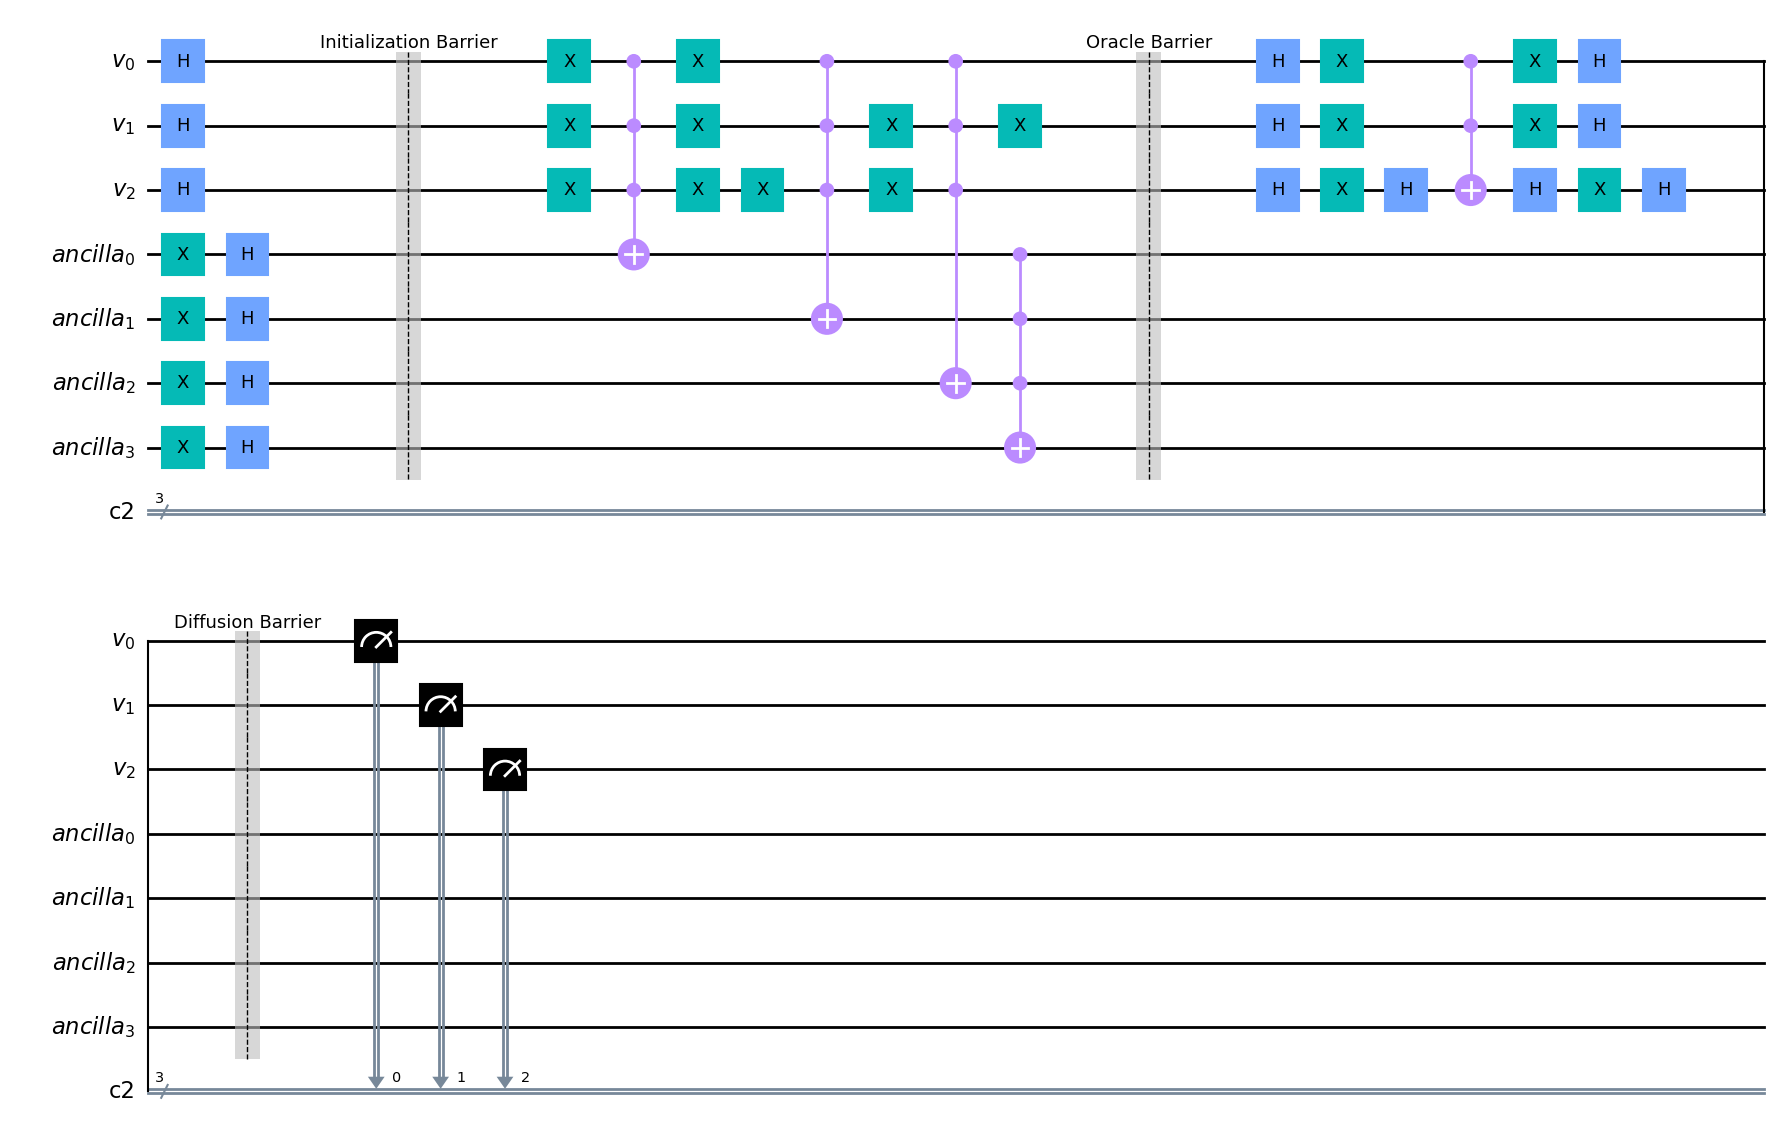

In [10]:
solutions = ["000","110","101"]
N = 2**len(solutions[0])
iterations = int(np.pi/4*np.sqrt(N/len(solutions))) #1

qc = executeGroover3SAT(iterations,solutions)
qc.draw(output="mpl")

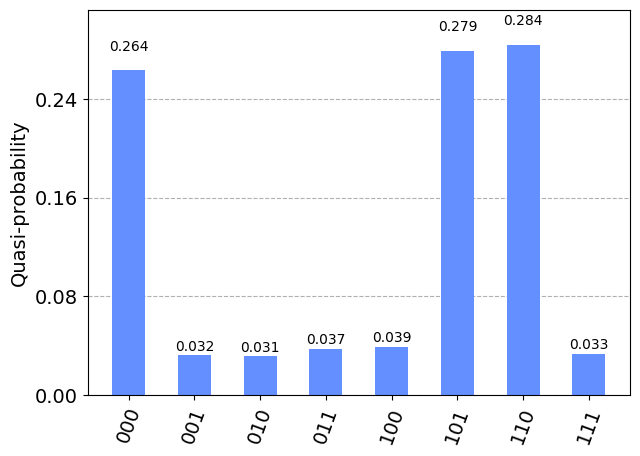

In [13]:
counts = execute_circuit(qc, reversed=True)
plot_distribution(counts)

### Para um número de iterações diferente do "ideal"

In [26]:
solutions = ["000","110","101"]
iterations = 3

qc = executeGroover3SAT(iterations,solutions)
#qc.draw(output="mpl")

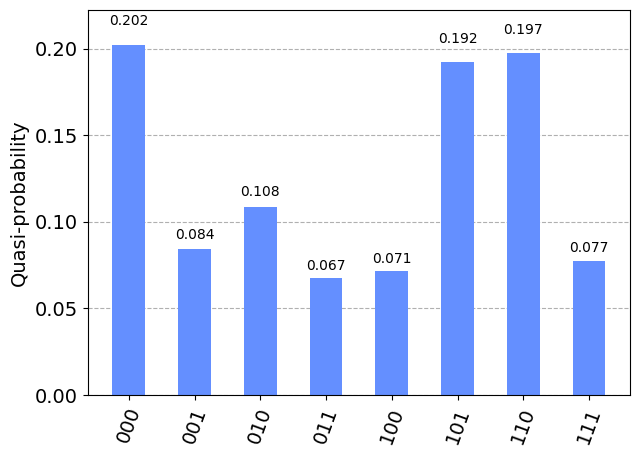

In [27]:
counts = execute_circuit(qc, reversed=True)
plot_distribution(counts)

Para o número de iterações igual a 3, constatamos que as probabilidades de obtermos resultados favoráveis são inferiores face às retornadas pelo número de iterações ideal.

In [25]:
solutions = ["000","110","101"]
iterations = 5

qc = executeGroover3SAT(iterations,solutions)
#qc.draw(output="mpl")

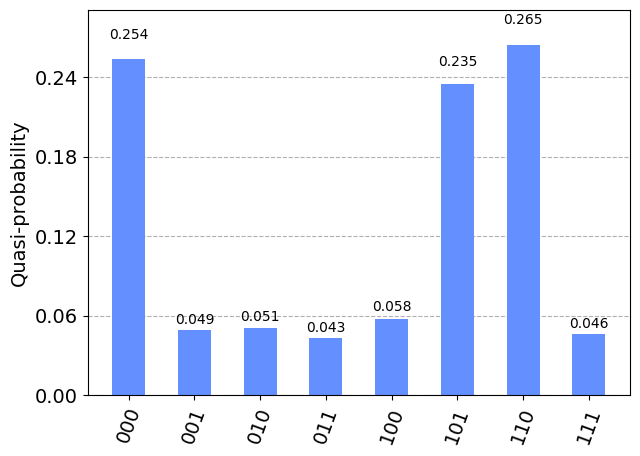

In [20]:
counts = execute_circuit(qc, reversed=True)
plot_distribution(counts)

Para o número de iterações igual a 5, constatamos que as probabilidades de obtermos resultados favoráveis são inferiores face às retornadas pelo número de iterações ideal.

In [23]:
solutions = ["000","110","101"]
iterations = 200

qc = executeGroover3SAT(iterations,solutions)
#qc.draw(output="mpl")

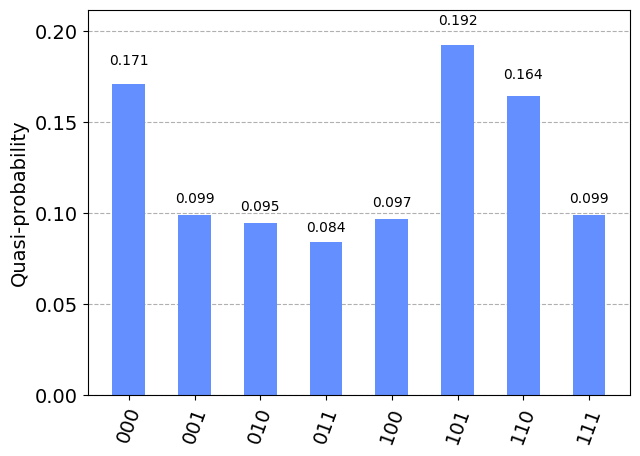

In [24]:
counts = execute_circuit(qc, reversed=True)
plot_distribution(counts)

Para o número de iterações igual a 200, constatamos que as probabilidades de obtermos resultados favoráveis são inferiores face às retornadas pelo número de iterações ideal.

## Conclusão
Teoricamente teríamos igual probabilidade de obter os resultados |000>, |101>, |110>, isto é, aproximadamente 0.33. Constatamos no entanto que no nosso melhor caso, para uma iteração, temos um resultado com probabilidades de 0.264, 0.279 e 0.284 respetivamente, o que são ligeiramente afastados do ideal.

Concluimos portanto que no nosso melhor caso o resultado ficou aquem das expectativas.

# Funções Auxiliares

In [12]:
def expression(v1,v2,v3):
    return int((not v1 or not v2 or not v3) and (v1 or not v2 or  v3) and (v1 or v2 or not v3) and (v1 or not v2 or not v3) and (not v1 or v2 or v3))

def drawTable():
    table ={"v1":[], "v2":[], "v3":[], "f":[], "Comentário":[]}
    for v1 in range(2):
        for v2 in range(2):
            for v3 in range(2):
                table["v1"].append(v1)
                table["v2"].append(v2)
                table["v3"].append(v3)
                result = expression(v1,v2,v3)
                table["f"].append(result)
                if result==1:
                    table["Comentário"].append("Solução")
                else:
                    table["Comentário"].append("Não é solução")        
    print(tabulate(table, tablefmt="fancy_grid", headers="keys")) 